In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils.methods import data_formatting, dict_mapping
from utils.setup import df_config
from utils.map import df_map_features

# Load dataset from .dat
df = pd.read_csv("../data/imports-85.data", names=df_config["head"])

# Set target feature:
target: str = "fuel-type"

# Set features to be processed:
features: list = [
    "brand",
    "aspiration",
    "num-of-doors",
    "body-style",
    "drive-wheels",
    "engine-location",
    "wheel-base",
    "length",
    "width",
    "height",
    "curb-weight",
    "engine-type",
    "num-of-cylinders",
    "engine-size",
    "fuel-system",
    "bore",
    "stroke",
    "compression-ratio",
    "horsepower",
    "peak-rpm",
    "city-mpg",
    "highway-mpg",
    "price"
]

# Format the dataset: Splitting into completely existend dataframe
# (used for modeling) and dataframe with missing values (used for evaluation)
train_vals, eval_vals, target_vals, target_eval_vals = data_formatting(
    df, target, features)


In [2]:
from utils.pcatsne import standardized_pca

# Experimenting with n_components to get a good variance ratio
n_components = 11

pca, x_pca = standardized_pca(train_vals, n_components)
xspca, xs_pca = standardized_pca(eval_vals, n_components)

# print(f"Components:\n{pca.components_}")
# print(f"Explained Variance:\n{pca.explained_variance_}")
# print(f"Explained Variance Ratio:\n{pca.explained_variance_ratio_}")
print(f"Sum of Explained Variance Ratio:\n{sum(pca.explained_variance_ratio_)}")
print(f"Sum of Explained Variance Ratio:\n{sum(xspca.explained_variance_ratio_)}")


Sum of Explained Variance Ratio:
0.9165779169735107
Sum of Explained Variance Ratio:
1.0


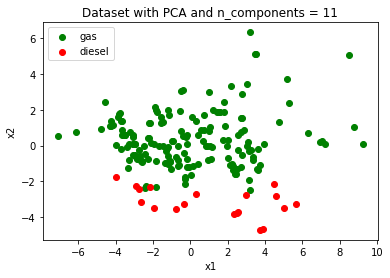

In [3]:
from utils.plotting import plot_dataset_pcatsne

plot_dataset_pcatsne(x_pca, target_vals, "Dataset with PCA and n_components = %i" %
                 n_components, ["diesel", "gas"])


In [4]:
# Find number of dimensions to "explain" 90% of variance

for n_components in range(1, train_vals.shape[1]):
    pca, x_pca = standardized_pca(train_vals, n_components)
    explained_variance_ratio = sum(pca.explained_variance_ratio_)

    print(
        f"Sum of Explained Variance Ratio: {round(explained_variance_ratio, 4)} with: {n_components} components.")

    if explained_variance_ratio > 0.90:
        _n_components = n_components
        break
    else:
        best_explained_variance_ratio = explained_variance_ratio


Sum of Explained Variance Ratio: 0.393 with: 1 components.
Sum of Explained Variance Ratio: 0.5269 with: 2 components.
Sum of Explained Variance Ratio: 0.6019 with: 3 components.
Sum of Explained Variance Ratio: 0.6672 with: 4 components.
Sum of Explained Variance Ratio: 0.7273 with: 5 components.
Sum of Explained Variance Ratio: 0.7749 with: 6 components.
Sum of Explained Variance Ratio: 0.817 with: 7 components.
Sum of Explained Variance Ratio: 0.8467 with: 8 components.
Sum of Explained Variance Ratio: 0.8738 with: 9 components.
Sum of Explained Variance Ratio: 0.8962 with: 10 components.
Sum of Explained Variance Ratio: 0.9166 with: 11 components.


In [5]:
# Split dataset in trianset and testset
from sklearn.model_selection import train_test_split

pca, x_pca = standardized_pca(train_vals, _n_components)
xspca, xs_pca = standardized_pca(eval_vals, _n_components)

# Split train/test of main dataset (train_vals)
x_train, x_test, y_train, y_test = train_test_split(
    x_pca, target_vals, test_size=0.35, random_state=15)


In [6]:
# KNN procedure, finding optimal neighbour parameter
from sklearn.neighbors import KNeighborsClassifier

best_score = 0.0
for i in range(1, 11):
    n_neighbors = i
    neigh = KNeighborsClassifier(n_neighbors=n_neighbors)
    neigh.fit(x_train, y_train)
    score = neigh.score(x_test, y_test)

    if score > best_score:
        best_score, _n_neighbors = score, n_neighbors
        print("Score: ", score, " with: ", n_neighbors, " neighbors.")


Score:  1.0  with:  1  neighbors.


In [7]:
for weights in ['uniform', 'distance']:
  neigh = KNeighborsClassifier(n_neighbors=_n_neighbors, weights=weights)
  neigh.fit(x_train, y_train)

  # Get predicted result and storing it in a dataframe
  result = neigh.predict(xs_pca)
  result = pd.DataFrame(
      {'predicted fuel-type': result, 'actual fuel-type': target_eval_vals})
  # Replace the logical values with their corresponding fuel-types
  result = result.replace(df_map_features["fuel-type-back"][0])

  print(f"Result for {weights}-classifier:\n{result}\n")


Result for uniform-classifier:
   predicted fuel-type actual fuel-type
0                  gas              gas
1                  gas              gas
2                  gas              gas
3                  gas              gas
4                  gas              gas
5                  gas              gas
6                  gas              gas
7                  gas              gas
8               diesel           diesel
9                  gas              gas
10                 gas              gas
11                 gas              gas

Result for distance-classifier:
   predicted fuel-type actual fuel-type
0                  gas              gas
1                  gas              gas
2                  gas              gas
3                  gas              gas
4                  gas              gas
5                  gas              gas
6                  gas              gas
7                  gas              gas
8               diesel           diesel
9               

Sum of Explained Variance Ratio:
0.526854861329253


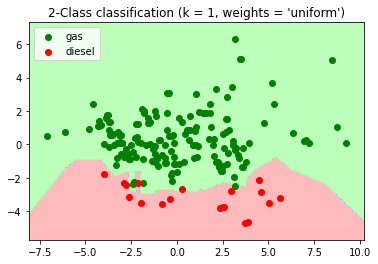

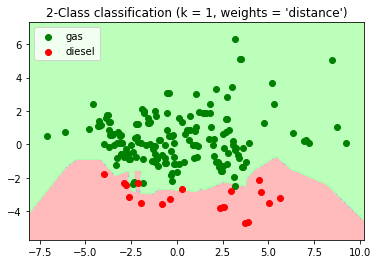

In [8]:
from utils.plotting import plot_knn_boundaries

# Plotting in 2-D, so PCA with n_components=2 has to be applied
# Therefore the "explained" variance ratio of the dataset drops significantly
# and should only be used for visualization, not predicting!
n_components = 2
pca2d, x_pca2d = standardized_pca(train_vals, n_components)

print(
    f"Sum of Explained Variance Ratio:\n{sum(pca2d.explained_variance_ratio_)}")

x_train, x_test, y_train, y_test = train_test_split(
    x_pca2d, target_vals, test_size=0.20, random_state=2)

for weights in ['uniform', 'distance']:
  neigh = KNeighborsClassifier(n_neighbors=_n_neighbors, weights=weights)
  neigh.fit(x_train, y_train)

  plot_knn_boundaries(x_pca2d, target_vals, neigh, "2-Class classification (k = %i, weights = '%s')"
                      % (_n_neighbors, weights), ["diesel", "gas"])
